==============================================================================================
# Practicum 5

==============================================================================================

## Delivery

Your overall grading will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented exhaustively and in **English**. 

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Answers to questions also need to be in **English**.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- The deliverable of both parts must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook (upload the ones that were not provided)
    
- It is required that your code can be run by us without need of any modification and without getting any errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please refrain from utilizing resources like ChatGPT to complete this lab assignment.


**Deadline: December 22th, 23:00 h**

==============================================================================================

This lab covers the following topics: 
* Gaussian filters
* Descriptors based on texture
* Distance between images and similarity search
* Face detection using:
    * Haar-like features
    * Adaboost
    * PCA



==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.



### Imports

In [1]:
%matplotlib inline

# GENERAL ONES FOR IMAGE ANALYSIS
import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from time import time
from scipy.ndimage import convolve

### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

# Derivative of Gaussians aka Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Derivative-of-Gaussians or as known as Leung-Malik (LM) Filter Bank.

<img src="./images/filter_bank.png">


We import Leung-Malik filters as follows:

In [2]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()
# NOTE: If this does not work, go to appendix for function code

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


### Plotting all filters

Plot the created filters as images similar to the figure above.

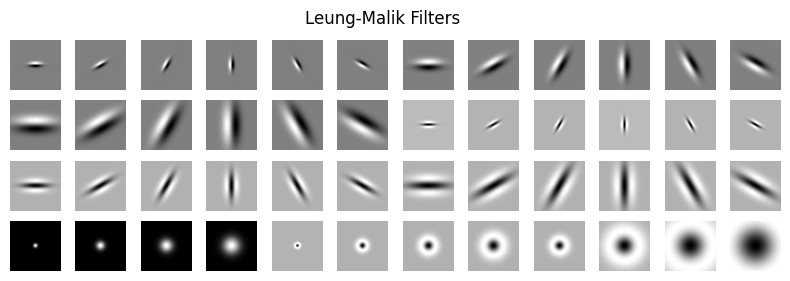

In [3]:
# Specifies the number of rows and columns for the figure
nrows = 4
ncols = 12

# Creates a figure to plot Leung-Malik filters
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 3))
# Adds a title to the figure
fig.suptitle('Leung-Malik Filters')

# Iterates over the 48 filters to display them in a 12 by 12 grid across 4 rows
for i in range(nrows):

    # Calculates the range to retrieve the filters
    _from = i * 12
    _to = (i + 1) * 12

    # Selects the filters
    filters = filter_bank[:,:, _from:_to]

    # Adds each filter to its respective row
    for j in range(ncols):
        axs[i][j].axis('off')
        axs[i][j].imshow(filters[:,:,j], cmap='gray')

# Displays the generated figure
plt.show()

## 1. Extracting a feature vector for an image

**1.1** Read the image ``/images/pizza.jpg``, and resize it to 240𝑥240 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

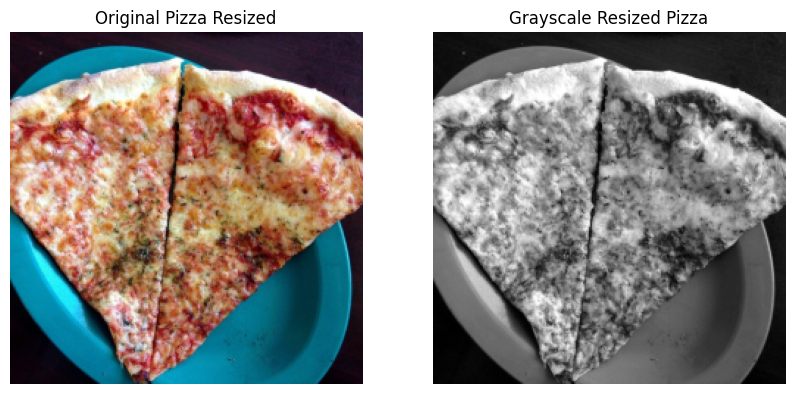

In [4]:
# Reads the image
pizza_rgb = io.imread('images/pizza.jpg')

# Resizes the image to 240x240x3
pizza_rgb = resize(pizza_rgb, (240, 240, 3))

# Converts the image to grayscale
pizza_gray = rgb2gray(pizza_rgb)

# Stores the images and their labels
images = [pizza_rgb, pizza_gray]
labels = ['Original Pizza Resized', 'Grayscale Resized Pizza']

# Creates a figure to plot the images
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

# Plots the images in the figure with their labels
for i, (img, lab) in enumerate(zip(images, labels)):

    # Sets up the subplot
    axs[i].axis('off')
    axs[i].set_title(lab)

    # Adds the image to the plot
    if img.ndim == 2:
        axs[i].imshow(img, cmap='gray')
    else:
        axs[i].imshow(img)

# Displays the generated figure
plt.show()

**1.2** Given $D=n\_{filters}$ filters from the filter bank and a single image `image`, make a function `get_image_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the **mean of the absolute value of the convolved image** by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image. Use a small number of filters to try your functions

In [5]:
def convert_to_grayscale(image: np.ndarray) -> np.ndarray:
    '''
    Converts an image to grayscale if it is RGB or RGBA.

    Args:
        image: The image to be converted.
    
    Returns:
        The image converted to grayscale.
    '''

    if image.ndim == 3:  # Checks if the image isn't grayscale
        if image.shape[2] == 4:  # Checks if it's an RGBA image
            image = rgba2rgb(image)

        if image.shape[2] == 3:  # Checks if it's an RGB image
            image = rgb2gray(image)

    return image


def get_image_features(image: np.ndarray, filter_bank: np.ndarray, n_filters: int) -> np.ndarray:
    '''
    Returns the feature vector of an image from a filter bank.

    Args:
        image: Source image from which to extract features.
        filter_bank: Set of filters to apply.
        n_filters: Number of filters to be applied from the filter bank.

    Returns:
        A vector (list) with n_filters elements representing the mean of the absolute image values with the first n_filters filters convolved.
    '''

    image = convert_to_grayscale(image)  # Ensures the image is in grayscale

    # Gets the first n filters of the bank
    filters = [filter_bank[:,:,i] for i in range(n_filters)]

    # Calculates the feature vector
    features = [np.absolute(convolve(image, f)).mean() for f in filters]

    return np.array(features)

In [6]:
## Try the function
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
im_features

array([0.01601096, 0.01450635, 0.01425211, 0.01591052, 0.01726204])


**1.3** (Optional) Try ``get_image_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [7]:
# Loads, resizes and converts the images to grayscale
gray_dog = rgb2gray(resize(io.imread('images/dog.jpg'), (250, 250, 3)))
gray_flower = rgb2gray(resize(io.imread('images/flower.jpg'), (250, 250, 3)))

# Gets the images features vectors
dog_features = get_image_features(gray_dog, filter_bank, n_filters)
flower_features = get_image_features(gray_flower, filter_bank, n_filters)

# Prints each feature vector
print(f'Grayscale dog features vector: {dog_features}')
print(f'Grayscale flower features vector: {flower_features}')

Grayscale dog features vector: [0.00661994 0.00651979 0.00757997 0.00877453 0.00857683]
Grayscale flower features vector: [0.01105603 0.01192169 0.01357841 0.01415647 0.01299551]


### Visualizing features

**1.4** Make a function `visualize_features(im,  filter_bank, n_filters=5)` that receives the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [8]:
def visualize_features(im: np.ndarray, filter_bank: np.ndarray, n_filters: int = 5) -> None:
    '''
    Displays the result of the convolving an image with the first n Leung-Malik filters.

    Args:
        im: The 2D array representation of an image.
        filter_bank: A 3D matrix containing the Leung-Malik filters.
        n_filters: An integer specifying the number of filters to be applied.
    '''

    im = convert_to_grayscale(im)  # Ensures the image is in grayscale

    # Creates a figure to plot the images and filters
    fig, axs = plt.subplots(2, n_filters, figsize=(10, 4))

    # Gets the first n filters of the bank
    filters = [filter_bank[:,:,i] for i in range(n_filters)]

    # Adds the images convolved with each filter and the filters to the figure
    for i, f in enumerate(filters):
        axs[0][i].axis('off')
        axs[1][i].axis('off')

        axs[0][i].imshow(convolve(im, f), cmap='gray')
        axs[1][i].imshow(f, cmap='gray')

    # Displays the generated figure
    plt.show()

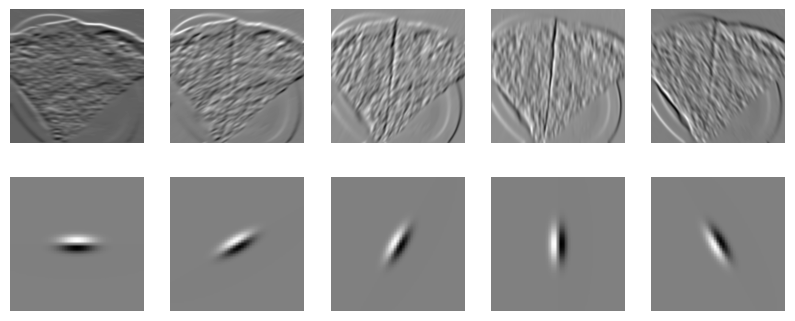

In [9]:
## Try the function
visualize_features(pizza_gray, filter_bank)

**1.5** (Optional) Try ``visualize_features()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

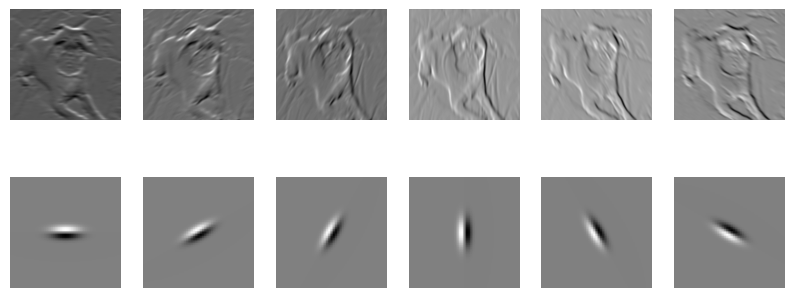

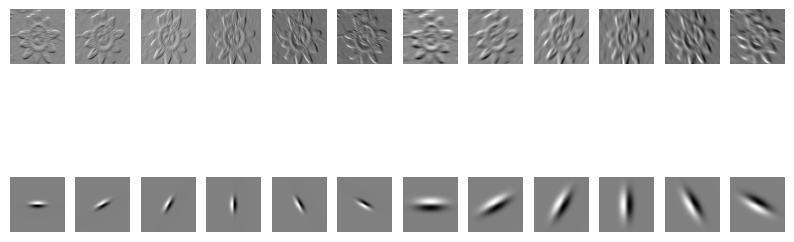

In [10]:
visualize_features(gray_dog, filter_bank, 6)
visualize_features(gray_flower, filter_bank, 12)

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resize them to 240x240 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

In [11]:
# Loads the 3 sets of images
pets_images = io.ImageCollection('images/pets/*')
pizza_images = io.ImageCollection('images/pizza/*')
flowers_images = io.ImageCollection('images/flowers/*')

# Resize the images in each set to 240x240x3 pixels
pets_images = [resize(img, (240, 240, 3)) for img in pets_images]
pizza_images = [resize(img, (240, 240, 3)) for img in pizza_images]
flowers_images = [resize(img, (240, 240, 3)) for img in flowers_images]

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

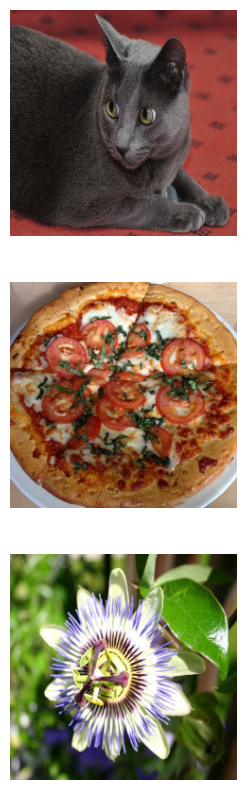

In [12]:
# Creates the figure and sets its size
plt.figure(figsize=(10, 10))

# Plots the first image from the pets set
ax = plt.subplot(3, 1, 1)
ax.axis('off')
ax.imshow(pets_images[0], cmap='gray')

# Plots the first image from the pizzas set
ax = plt.subplot(3, 1, 2)
ax.axis('off')
ax.imshow(pizza_images[0], cmap='gray')

# Plots the first image from the flowers set
ax = plt.subplot(3, 1, 3)
ax.axis('off')
ax.imshow(flowers_images[0], cmap='gray')

# Displays the generated figure
plt.show()

How many images there are in **each** directory?

In [13]:
# Prints the number of images in each set
print(f'Pets has: {len(pets_images)} images')
print(f'Pizzas has: {len(pizza_images)} images')
print(f'Flowers has: {len(flowers_images)} images')

Pets has: 29 images
Pizzas has: 30 images
Flowers has: 29 images


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank, n_filters=6)` that applies `get_image_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [14]:
def get_dataset_features(all_images: list[np.ndarray], filter_bank: np.ndarray, n_filters: int = 6) -> np.ndarray:
    '''
    Gets the feature vector of a group of images using a filter bank.

    Args:
        all_images: A list containing all the images to be processed.
        filter_bank: A numpy array  with the filters to be applied.
        n_filters: Integer specifying the lenght of the feature vector.
    
    Returns:
        An array containing the feature vector of the group images.
    '''
    
    # List to save the features vectors of the images bank
    matrix = []

    # Extracts the feature vector of each image and adds them to the matrix
    for img in all_images:
        matrix.append(get_image_features(img, filter_bank, n_filters))
    
    return np.array(matrix)


In [15]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors = get_dataset_features(all_images, filter_bank, n_filters)

Print the shape of `feature_vectors` as well as the features for image #3 (*i.e. all_images[2]*), image #33, and image #53, directly from the vector

In [16]:
print(f'Feature vectors shape: {(feature_vectors.shape)}')  # Displays the shape of the feature vectors
print(f'Features image 3: {feature_vectors[2]}')  # Displays the feature vector of image 3
print(f'Features image 33: {feature_vectors[32]}')  # Displays the feature vector of image 33
print(f'Features image 53: {feature_vectors[52]}')  # Displays the feature vector of image 53

Feature vectors shape: (88, 5)
Features image 3: [0.0221201  0.01997434 0.01646411 0.01580279 0.01848019]
Features image 33: [0.01975618 0.01761501 0.01502625 0.01281543 0.01418061]
Features image 53: [0.00725024 0.00788163 0.00933855 0.01017146 0.00921708]


### Visualizing the features of an image

**2.3** Define a function `visualize_features_imgs(im_index, feature_vector)` that given n different images, plots their features. Use different colors to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

<img src="./images/example_plot_features.jpg" >


In [17]:
def visualize_features_imgs(im_index: list[int], feature_vectors: np.ndarray) -> None:
    '''
    Displays a plot of the features vector of a set of images.

    Args:
        im_index: list with the indices of the images to plot.
        feature_vectors: A numpy array with the feature vectors of the images.
    '''

    # Plots the feature vectors of the images
    for idx in im_index:
        features = feature_vectors[idx]  # Gets the feature vector of the image 
        x = [j for j in range(len(features))] # Calculates the features positions
        plt.plot(x, features, 'o-', label=f'image {idx + 1}')  # Plots the values to the figure
    
    # Displays the figure with the plot
    plt.legend()
    plt.show()


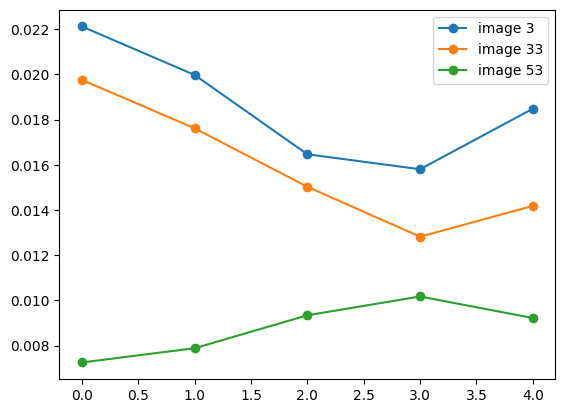

In [18]:
## Try the function
visualize_features_imgs([2,32,52], feature_vectors)


# 3 Retrieving the most similar images

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**3.1** Implement a function `retrieve_images(im_features, feature_vectors, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be feature of the image of interest `im_features`, the whole data set features `feature_vectors`, and an integer value `k`, which defines the number of images.

The function should return the ordered vector of distances and the index of the closests images.

In [19]:
from math import sqrt

def l2_norm(a: np.ndarray, b: np.ndarray) -> float:
    '''
    Calculates the L2 norm (Euclidean distance) between two vectors.

    Args:
        a: A numpy array representation of a vector.
        b: A numpy array representation of a vector.

    Returns:
        The distance between both vectors.
    '''

    return sqrt(np.sum((a - b)**2))


def retrieve_images(im_features: np.ndarray, feature_vectors: np.ndarray, k: int = 5) -> (tuple[int], tuple[float]):
    '''
    Retrieves the k closest images from a source one.

    Args:
        im_features: Vector with the query image features extracted using Leung-Malik filters.
        feature_vectors: A list with the features vectors of other images.
        k: Integer specifying the number of retrievals.

    Returns:
        A tuple with the distances bewteen the query image and the most similar ones, and a tuple with the indices of the most similar images.
    '''
    
    # List to save the tuple of the images' distances and their indices
    images = []

    # Calculates the distances of the images
    for i, features in enumerate(feature_vectors):
        distance = l2_norm(im_features, features)
        images.append((distance, i))  # Apends the image distance and its index 

    # Sort images by distance
    images = sorted(images, key=lambda x: x[0])

    return zip(*images[:k])
        

Try your function using ``/images/pizza.jpg``.

In [20]:
# Try your function
distances, closest = retrieve_images(im_features, feature_vectors, k = 5)
print(closest, distances)

(5, 35, 87, 11, 86) (0.0, 0.002396536621999983, 0.002881583818509064, 0.0030827571317625464, 0.0033379607400700856)


**3.2** Write a function *show_closest_images(all_images, closest, distances)* to show the closest images and the corresponding distances. 

<img src="./images/indice.png" >


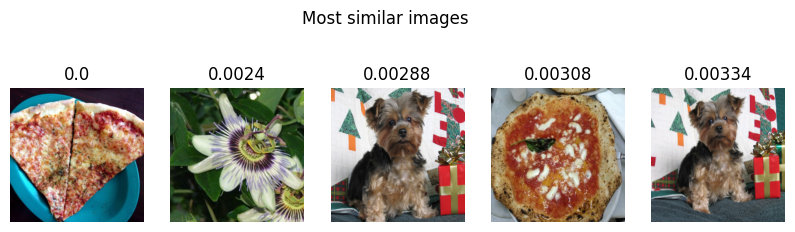

In [21]:
def show_closest_images(all_images: np.ndarray, closest: list[int], distances: list[float]) -> None:
    '''
    Displays the most similar images and their distances after calculate them with `retrieve_images()`.

    Args:
        all_images: An array with all the images.
        closest: A list with the index of the closest images.
        distances: A list with the distance of the closest images.
    '''

    # Calculates the number of columns to plot
    columns = len(distances)

    # Creates the figure to display the images
    fig, axs = plt.subplots(1, columns, figsize=(10, 3))

    # Adds the images to the figure and their distance as title
    for i, (idx, distance) in enumerate(zip(closest, distances)):
        axs[i].axis('off')
        axs[i].set_title(round(distance, 5))
        axs[i].imshow(all_images[idx], )
    
    # Displays the generated figure
    plt.suptitle('Most similar images')  # Adds a superior title to the figure
    plt.show()

show_closest_images(all_images, closest, distances)

# 4 Compute the accuracy of the algorithm: given a query image. 

**4.1** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [26]:
def search_equal(feature_vectors: np.ndarray, im_features: np.ndarray) -> int:
    '''
    Search for an image into a set of images by comparing its features vector.

    Args:
        feature_vectors: An array with the feature vectors of the set of images.
        im_features: The features vector of the source image.

    Returns:
        An integer with the index of the image into the set. Returns None if the image is not found.
    '''

    # Loop index
    i = 0

    # Search over the feature vectors array
    while i < len(feature_vectors):
        # Checks if each component of the vector are equal to the source image
        if (feature_vectors[i] == im_features).all():
            return i
        i += 1
    
    return None


def accuracy(feature_vectors: np.ndarray, class_labels: np.ndarray, im_features: np.ndarray, class_im: int, k: int = 5) -> float:
    '''
    Calculates the accuracy of the image retrieving using the features vector method.

    Args:
        feature_vectos: A 2D numpy array with the feature vector of the images.
        class_labels: A numpy array with the class label of each image.
        im_features: A numpy array with the features of the image.
        class_im: An integer specifying the class of the query image.
        k: An integer specifying the number of retrievals.

    Returns:
        A value that represents the accuracy as percentage.
    '''
    
    # Search for the image into the set
    idx = search_equal(feature_vectors, im_features)

    # Deletes the image from the set if is part of it
    if idx:
        feature_vectors = np.delete(feature_vectors, idx, axis=0)

    # Gets the distances and the indices of the most similar image
    distances, closest = retrieve_images(im_features, feature_vectors, k)

    counter = 0

    # Counts how many images have the same class of the query image
    for idx in closest:
        if class_labels[idx] == class_im:
            counter += 1

    return counter / k

In [27]:
# Creates a list with the class labels of each image

pets_class = [2 for i in range(len(pets_images))]
pizza_class = [0 for i in range(len(pizza_images))]
flowers_class = [1 for i in range(len(flowers_images))]

class_labels = pizza_class + flowers_class + pets_class

In [28]:
print("acc:", accuracy(feature_vectors, class_labels, im_features, 0 , k = 5))

acc: 0.2


Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

In [32]:
print("acc:", accuracy(feature_vectors, class_labels, im_features, 0 , k = 10))

acc: 0.2


### Feature normalization

**4.3** As you can see in exercise 2.4, some features are higher than the rest and, therefore, they are "more important" during the image retrieving.

Normalize each feature between **[0,1]** using the minimum and the maximum values obtained from `feature_vectors`. Note that we need to use these values to normalize `im_features`.

* Plot the new features of an image, using `visualize_features_imgs()`. 
* Then, show the 5 closest images (use show_closest_images) from `im_features`
* Compute the accuracy. 

**Is there any difference? Do we obtain the same images than previously?**

[[0.01743331 0.01657557 0.01490646 0.01371067 0.01423056]
 [0.01031558 0.01091477 0.01144574 0.01158473 0.01092441]
 [0.0221201  0.01997434 0.01646411 0.01580279 0.01848019]]


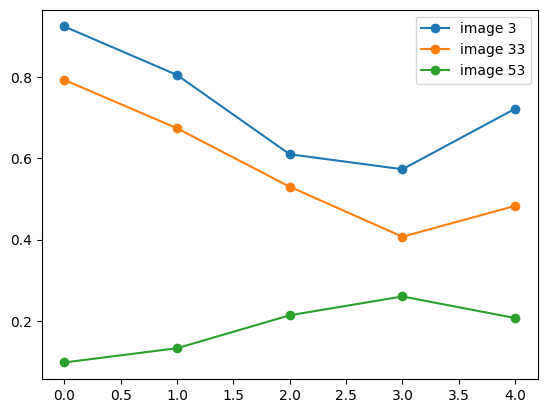

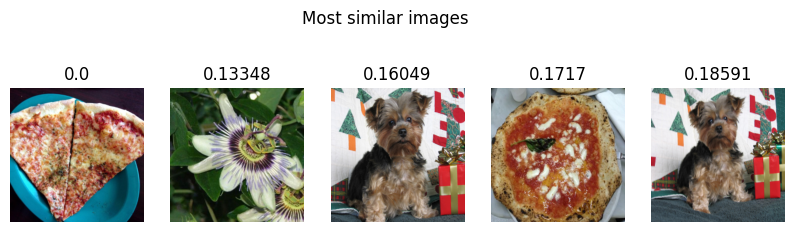

In [34]:
# Your solution here
print(feature_vectors[:3])

im_norm_features = (im_features - feature_vectors.min()) / (feature_vectors.max() - feature_vectors.min())
norm_feature_vectors = (feature_vectors - feature_vectors.min()) / (feature_vectors.max() - feature_vectors.min())

visualize_features_imgs([2,32,52] , norm_feature_vectors)
distances, closest = retrieve_images(im_norm_features, norm_feature_vectors, k = 5)
show_closest_images(all_images, closest, distances)

# 5 Image retrieval based on texture and color. 

**5.1** Make a function ` lm_features_rgb(rgb_image, n_bins=12)`  that returns the features based on a color descriptor (using histograms, similar to what it was performed in the **Deliverable 3 - video segmentation**). 

**Hint:** Consider each bin from each channel as a feature, create a vector with all the features together. 

In [35]:
from skimage.exposure import histogram
from skimage.util import img_as_float

def lm_features_rgb(rgb_image: np.ndarray, n_bins: int = 12) -> np.ndarray:

    [hist_r, bins_r] = histogram((img_as_float(rgb_image)[:,:,0]), n_bins)
    [hist_g, bins_g] = histogram((img_as_float(rgb_image)[:,:,1]), n_bins)
    [hist_b, bins_b] = histogram((img_as_float(rgb_image)[:,:,2]), n_bins)

    hist_im = np.array(hist_r + hist_g + hist_b)

    return hist_im

In [36]:
# Try your function
lm_rgb_features = lm_features_rgb(pizza_rgb)
print(len(lm_rgb_features))

12



## Apply the function to all the images in the dataset

**5.2** Using ` lm_features_rgb` build the features of all the datapoints in  `all_images` and save them in `lm_dataset_features`.

In [37]:
%%time 

matrix = []

for img in all_images:
    matrix.append(lm_features_rgb(img))

lm_dataset_features = np.array(matrix)

CPU times: user 120 ms, sys: 11.3 ms, total: 131 ms
Wall time: 130 ms


## Compute the accuracy of the method using `lm_features_rgb`

**5.3** Compute the accuracy of the retrieved images using the features that contain color information. Show the 4 closest images to the query images in the `lm_rgb` space with the function built before.

Is the accuracy higher? Please, comment the results.

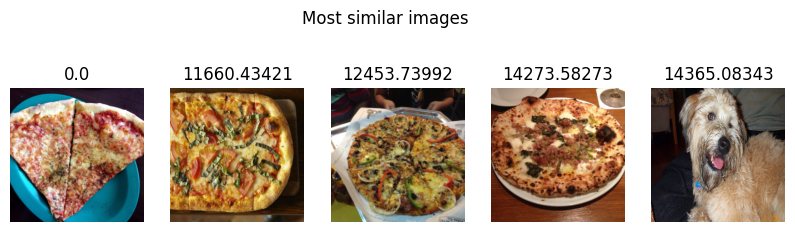

acc: 0.8


In [38]:
# Your solution here
distances, closest = retrieve_images(lm_rgb_features, lm_dataset_features)
show_closest_images(all_images, closest, distances)

print("acc:", accuracy(lm_dataset_features, class_labels, lm_rgb_features, 0 , k = 5))

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="images/haar-like.PNG">

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="images/haar-like1.PNG">


A real application would be:

<img src="images/face.PNG">


To describe the face, we can apply convolutions with Haar features.

### 6. Building integral image and Haar-like features

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="images/integral_image.PNG">

An example :

<img src="images/integral_image1.PNG">

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**6.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one. Refrain from using built-in functions that already do the integral, compute it yourself. 

In [39]:
def to_integral_image(source: np.ndarray) -> np.ndarray:
    '''
    Calculate the Integral Image of a 2D NumPy array.

    Args:
        source: 2D array

    Returns:
        integral_image: 2D array representing the Integral Image
    '''

    # Gets the source image dimensions
    height, width = source.shape

    # Creates an empty integral image
    integral_image = np.zeros((height + 1, width + 1))

    # Calculates the integral image
    for i in range(1, height + 1):
        for j in range(1, width + 1):
            integral_image[i, j] = integral_image[i - 1, j] + integral_image[i, j - 1] - integral_image[i - 1, j - 1] + source[i - 1, j - 1]
    
    return integral_image

In [40]:
random_img = np.random.randint(0, 10, (5, 5))
print(random_img)

[[5 6 6 8 5]
 [6 9 5 6 0]
 [7 3 9 1 2]
 [0 5 9 7 3]
 [4 2 6 3 7]]


In [41]:
# Visualizing results on a random grayscale image
integral_img = to_integral_image(random_img)
print(integral_img)

[[  0.   0.   0.   0.   0.   0.]
 [  0.   5.  11.  17.  25.  30.]
 [  0.  11.  26.  37.  51.  56.]
 [  0.  18.  36.  56.  71.  78.]
 [  0.  18.  41.  70.  92. 102.]
 [  0.  22.  47.  82. 107. 124.]]


To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [42]:
assert random_img.sum() == integral_img[-1,-1]
assert random_img[0,:].sum() == integral_img[1, -1]

**6.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

Here is an example (you don't have to pick this image, you can do it at random):
<img src="images/integral_image_example.jpg" width=500, height=250>

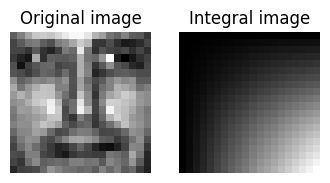

In [43]:
# Reads a face image
face_img = io.imread('images/faces/face00001.png')

# Creates the figure to plot the image and its integral image
fig, axs = plt.subplots(1, 2, figsize=(4,2))

# Sets the titles of the figure
axs[0].set_title('Original image')
axs[1].set_title('Integral image')

# Sets off the axis of the figure
axs[0].axis('off')
axs[1].axis('off')

# Plots the images into the figure
axs[0].imshow(face_img, cmap='gray')
axs[1].imshow(to_integral_image(face_img), cmap='gray')

# Displays the generated figure
plt.show()

**6.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage (no need to provide a written answer here, just make sure you are obtain same results).

In [44]:
# Imports integral_image from skimage to calculate the Integral Image of a 2D array
from skimage.transform import integral_image

integral_img = integral_image(random_img)

In [45]:
assert random_img.sum() == integral_img[-1,-1]
assert random_img[0,:].sum() == integral_img[0, -1]

## Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**6.4** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [46]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [55]:
def extract_feature_image(image, feature_type, feature_coord = None):
    
    # Converts the image to its integral image
    int_image = to_integral_image(image)

    # Extracts the image features
    features = haar_like_feature(int_image, 0, 0, int_image.shape[0], int_image.shape[1], feature_type, feature_coord)

    return features

**6.5** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="images/image1.png" width=600, height=300>

*Note that there are multiple features and therefore your results might not exactly match this example, depending on your selection.*

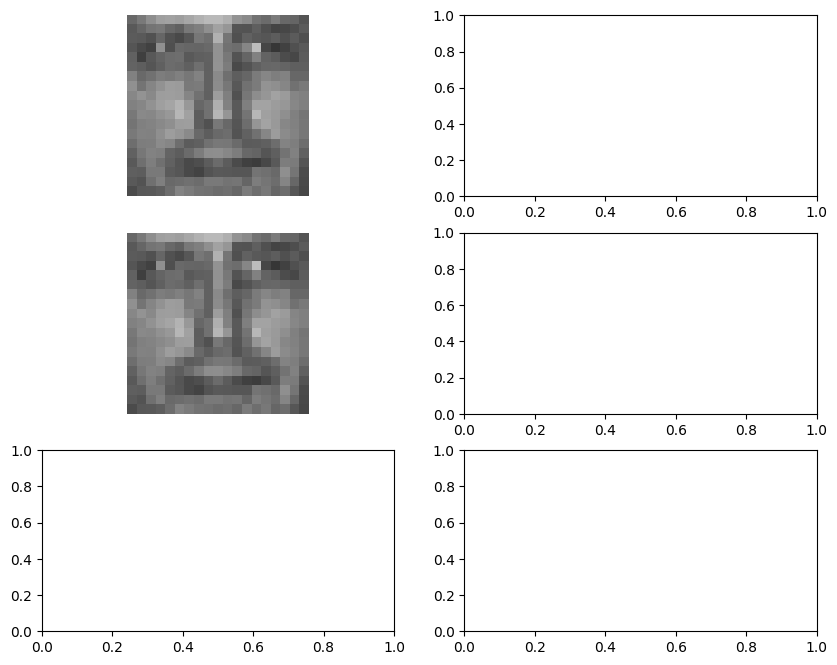

In [58]:
#your solution
def plotFeatures(image: np.ndarray, feature_types: list[str]) -> None:
    
    features = extract_feature_image(image, feature_types)
    feature_coord, feature_type = haar_like_feature_coord(1, 1, feature_types)

    fig, axs = plt.subplots(3, 2, figsize=(10, 8))

    for i in range(3):
        for j in range(2):
            if i != 2 and j != 1:
                image = draw_haar_like_feature(image, 0, 0, image.shape[0], image.shape[1], feature_coord)
                axs[i][j].axis('off')
                axs[i][j].imshow(image)

plotFeatures(io.imread('images/faces/face00001.png'), feature_types)


## 7 Face detection using an Adaboost

**7.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features (use the `built extract_feature_image` for this). 

Futhermore, build the class labels vector ``y`` with the label of all the images. Make sure both, images and labels are numpy array objects.

In [59]:
# Loads the images from faces and nonfaces directories
faces_collection = io.ImageCollection('images/faces/*')
non_faces_collection = io.ImageCollection('images/nonfaces/*')

images = []

for image in faces_collection:
    images.append(image)

for image in non_faces_collection:
    images.append(image)

features = [extract_feature_image(i, feature_types) for i in images]

**7.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Print the size of your images train and test set. 

In [ ]:
# Your solution here

**7.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

In [ ]:
# Your solution here

**7.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. Make sure to use your test set for this. What are these methods doing?

In [ ]:
# Your solution here

Change the parameter ``n_estimators`` and see what happens to the test set accuracy. Does the performance increased or decreased?

Try at least 3 different values of `n_estimators`

In [ ]:
# Your solution here

**7.5 (Optional)** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features of the model. 

In [ ]:
# Your solution here

==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 8. Load and prepare data for PCA

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**8.1** Load the dataset, obtaining only those cases where there are, **at least, 100 images**. Check the final number of images, image shapes and labels of the images.

*Hint: There is a parameter to set the minimum number of faces per person to load in the dataset function*

In [ ]:
# Your solution here

**8.2** Plot an image frome each example, with its name as the title of the image.

<img src="images/example.png" width=500, height=500>

In [ ]:
# Your solution here

**8.3** Divide the dataset into train and test set (0.7/0.3). Print the size of train and test image sets.

Hint: use the train_test_split function.

In [ ]:
# Your solution here

## Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**8.4** Create a PCA object, using the training set and 150 components. 

*Consider that PCA requires the data to be reshaped into 2 dimensions: number of observations x number of pixels*

In [ ]:
# Your solution here

Plot the accumated variance of the components. 

**Hint:** Use `explained_variance_ratio_` to return the variance explained, plot this.

<img src="images/explained_variance_example.jpg" width=400, height=400>

In [ ]:
# Your solution here

**8.5** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly


<img src="images/mean_face.jpg" width=200, height=200>


In [ ]:
# Your solution here

**8.6** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

In [ ]:
# Your solution here

**8.7** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="images/eigenfaces_image.PNG" width=300, height=300>

Example of output: 

<img src="images/recomposition_example.jpg" width=600, height=600>

In [ ]:
# Your solution here

In [ ]:
# Your solution here

## Train a classifier

**8.8** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [ ]:
# Your solution here

**8.9** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [ ]:
# Your solution here

## Recognize a new face example using the learned model

**8.10** Try your model using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="images/prediction.png" width=300 height = 300>

In [ ]:
# Your solution here

# Appendix

In case the library for exercise 1 does not work for you, here is the function that will create the filters for you:

In [ ]:
"""
Functions needed to create the Leung-Malik (LM) filter bank
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F